## Paper Sankey Diagram

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio   
pio.kaleido.scope.mathjax = None

import settings
from utils import vplot, vprint

##### Global Parameters

In [2]:
MANUAL_DIR = settings.DATA_CONFIG['manual_dir']
FRAMEWORKS = {v: k for k, v in settings.DATA_CONFIG['frameworks'].items()}

MANUAL_VULN_FILE = MANUAL_DIR + 'vulnerability_manual.xlsx'
MANUAL_SHEET_NAME = 'manual'

if not os.path.exists("imgs"):
    os.mkdir("imgs")

##### Load Data

In [3]:
def get_vuln_manual(filename, sheetname):
    return pd.read_excel(filename,sheet_name=sheetname)
df = get_vuln_manual(filename=MANUAL_VULN_FILE, sheetname=MANUAL_SHEET_NAME)

In [4]:
def summary(df, rank=20):
    total = len(df)
    tops = df['Taxonomy'].value_counts()[:rank].sum()
    percent = tops / total * 100
    print(f"Total Vuln {total}, Top{rank}: {percent:.2f}%")
summary(df,rank=20)

Total Vuln 3049, Top20: 81.80%


In [5]:
FIG_COLOR = [
 '#8ECFC9',
 '#FFBE7A',
 '#FA7F6F',
 '#82B0D2',
 '#BEB8DC',
 '#E7DAD2',
 '#2878b5',
 '#9ac9db',
 '#f8ac8c',
 '#c82423',
 '#ff8884',
]

#### Sankey Diagram

In [6]:
def plot_sankey(df, source_name, target_name, width=900, height=1000, path=None, 
                left_title=None,right_title=None, title_y=1.05, fontsize=18, margin=dict(l=5, r=5, t=30, b=20), pad=10):
    # labels
    def get_labels(stat):
        labels = list(stat.index)
        pct = np.array(stat.values / np.sum(stat.values) * 100)
        return [f'{v} ({pct[i]:.2f}%)'for i,v in enumerate(labels)], labels
    
    source_label_pcts, source_labels_names = get_labels(stat=df[source_name].value_counts())
    target_label_pcts, target_labels_names = get_labels(stat=df[target_name].value_counts())
    
    labels = source_label_pcts + target_label_pcts
    labels_name = source_labels_names + target_labels_names
    label_index_map = {}
    label_name_map = {}
    for i, l in enumerate(labels):
        label_index_map[l] = i
        label_name_map[labels_name[i]] = l
    
    # colors  
    colors = []
    def hex_to_rgb(hex):
        rgb = []
        hex = hex[1:]
        for i in (0, 2, 4):
            decimal = int(hex[i:i+2], 16)
            rgb.append(decimal)
        return tuple(rgb)
    
    # Color [Light24, G10, Plotly, D3]
    # px.colors.qualitative.D3
    
    for hex in list(FIG_COLOR):
        rgb = hex_to_rgb(hex)
        colors.append(f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{0.75})')
    
    # links
    sources, targets, values = [], [], []
    for key in list(df[source_name].value_counts().index):
        series = df[df[source_name] == key][target_name].value_counts()
        for index, value in series.items():
            sources.append(label_index_map[label_name_map[key]])
            targets.append(label_index_map[label_name_map[index]])
            values.append(value)
                
    label_l = source_labels_names
    label_r = target_labels_names
    offset = 0.001
    x = ([offset , ]*len(label_l)) + [1,]*len(label_r)
    y = list(np.linspace(offset,1,len(label_l))) + list(np.linspace(offset,1,len(label_r)))
    node = dict(pad = pad,
                thickness = 5,
                line = dict(color = "black", width = 1),
                label = labels,
                x = x,
                y = y,
                color = colors * (int(len(labels)/len(colors))+1))
    
    link = dict(source = sources, target = targets, value = values)
    link['color'] = [node['color'][src] for src in link['source']]

    fig = go.Figure(data=[go.Sankey(node = node, link = link, arrangement='snap')])    
    fig.update_layout(font_size=fontsize, width=width, height=height, margin=margin)
    
    if left_title:
        fig.add_annotation(text=f"<b>{left_title}</b>", x=0, y=title_y, showarrow=False)
    if right_title:
        fig.add_annotation(text=f"<b>{right_title}</b>", x=1, y=title_y, showarrow=False)

    
    fig.show()
    if path is not None:
        fig.write_image(f"imgs/{path}", format="pdf")

In [7]:
def calc_workload_by_code(df):
    data_col = 'Line Changed'
    col = 'Line Changed Group'
    df[col] = 'Unknown'
    df.loc[df[data_col] < 10, col] = '<10'
    df.loc[(df[data_col] >= 10) & (df[data_col] < 100), col] = '10~99'
    df.loc[(df[data_col] >= 100) & (df[data_col] < 1000), col] = '100~999'
    df.loc[(df[data_col] >= 1000), col] = '1000+'
    return df

### Figure 8: CWE pillar to line changed mapping.

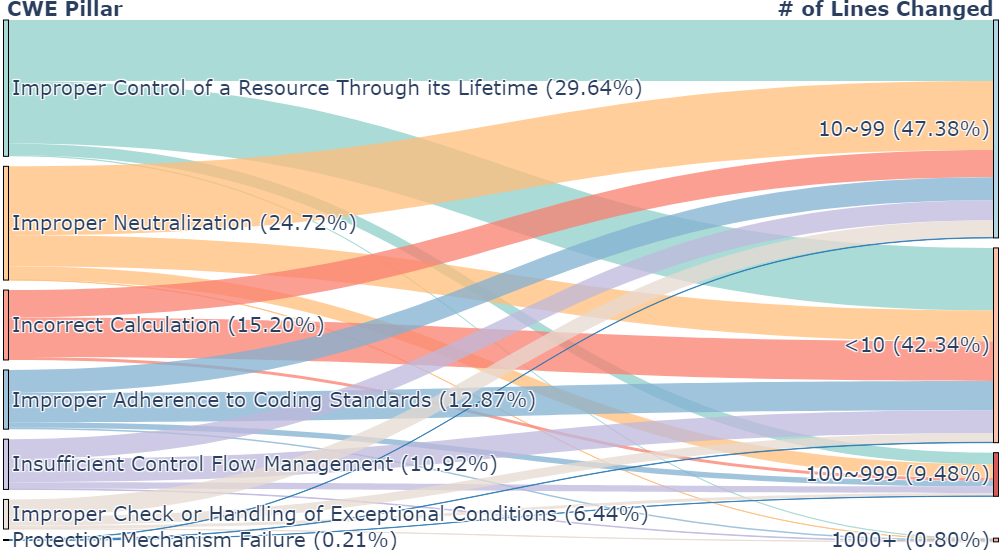

In [8]:
df_ = calc_workload_by_code(df)
# Ignore rows without Line changed records and rows without specific Pillar
df_ = df_[(df_['Source'] == 'Unofficial') & (df_['CWE Pillar'] != 'Other')]
# Ignore row without Pillar then reset index
df_ = df_[['CWE Pillar', 'Line Changed Group']].dropna().reset_index(drop=True)
plot_sankey(df=df_, source_name='CWE Pillar', target_name='Line Changed Group', width=1000, height=550, 
            path='pillar_to_line_changed.pdf', left_title='CWE Pillar', right_title='# of Lines Changed', title_y=1.05, 
            fontsize=20, margin=dict(l=5, r=5, t=20, b=10))

### Figure 9: Top 20 taxonomy to line changed mapping

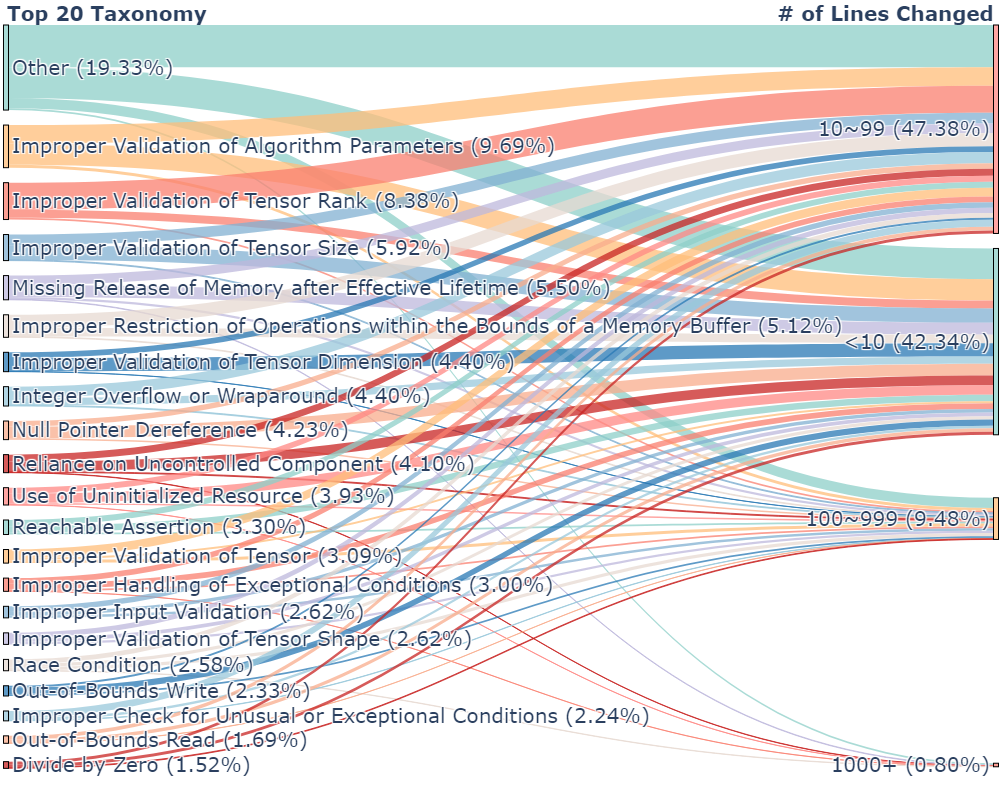

In [11]:
df_ = calc_workload_by_code(df)
# Ignore rows without Line changed records and rows without specific Pillar
df_ = df_[(df_['Source'] == 'Unofficial') & (df_['CWE Pillar'] != 'Other')]
# Ignore row without Pillar then reset index
df_ = df_[['Taxonomy', 'Line Changed Group']].dropna().reset_index(drop=True)
# Replace for Display
df_.loc[df_['Taxonomy'] == "Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition')",'Taxonomy']  = 'Race Condition'

RANK = 20
not_tops = df_['Taxonomy'].value_counts()[RANK:]
for key in list(not_tops.index):
    df_.loc[df_['Taxonomy'] == key,'Taxonomy']  = 'Other'

df_ = df_.reset_index(drop=True)

plot_sankey(df=df_, source_name='Taxonomy', target_name='Line Changed Group', width=1000, height=800, 
            path='tax_to_line_changed.pdf', left_title='Top 20 Taxonomy', right_title='# of Lines Changed',title_y=1.035, 
            fontsize=20, margin=dict(l=5, r=5, t=25, b=35),pad=15)

#### Figure 10: CWE to deep learning specific taxonomy mapping

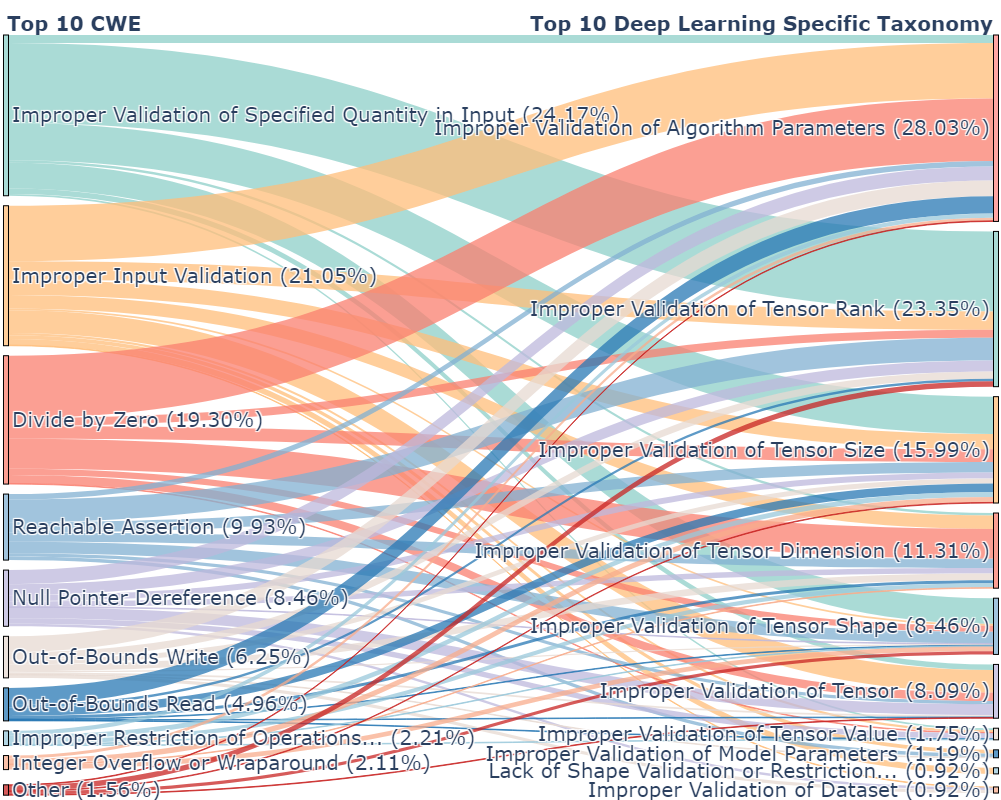

In [12]:
df_ = df.copy()
df_.loc[df_['CWE Name'] == "Improper Restriction of Operations within the Bounds of a Memory Buffer",'CWE Name']  = 'Improper Restriction of Operations...'
df_.loc[df_['Taxonomy'] == "Improper Restriction of Operations within the Bounds of a Memory Buffer",'Taxonomy']  = 'Improper Restriction of Operations...'
df_.loc[df_['Taxonomy'] == "Lack of Shape Validation or Restriction While Tensor Creation",'Taxonomy']  = 'Lack of Shape Validation or Restriction...'

df_ = df_[df_['Taxonomy'] != df_['CWE Name']].reset_index()

RANK = 10
not_tops = df_['CWE Name'].value_counts()[RANK:]
for key in list(not_tops.index):
    df_ = df_[df_['CWE Name'] != key]

not_tops = df_['Taxonomy'].value_counts()[RANK:]
for key in list(not_tops.index):
    df_ = df_[df_['Taxonomy'] != key]
    
df_ = df_.reset_index(drop=True)

plot_sankey(df=df_, source_name='CWE Name', target_name='Taxonomy', width=1000, height=800, path='cwe_to_dl_taxonomy.pdf', 
            left_title='Top 10 CWE', right_title='Top 10 Deep Learning Specific Taxonomy',title_y=1.035, 
            fontsize=20, margin=dict(l=5, r=5, t=35, b=10))

### Figure 11: Percentage of vulnerabilities in each framework

In [43]:
df_ = df[['CWE Pillar','Framework']].copy()
df_['Count'] = 0
df_['Count'] = df_.groupby(['CWE Pillar','Framework'])['CWE Pillar'].transform('count')
df_.loc[df['CWE Pillar'] == 'Improper Control of a Resource Through its Lifetime','CWE Pillar']  = 'Resource Control        '
df_.loc[df['CWE Pillar'] == 'Incorrect Calculation','CWE Pillar']                                = 'Incorrect Calculation '
df_.loc[df['CWE Pillar'] == 'Insufficient Control Flow Management','CWE Pillar']                 = 'Control Flow          '
df_.loc[df['CWE Pillar'] == 'Protection Mechanism Failure','CWE Pillar']                         = 'Protection Mechanism  '
df_.loc[df['CWE Pillar'] == 'Improper Check or Handling of Exceptional Conditions','CWE Pillar'] = 'Exceptional Conditions'
df_.loc[df['CWE Pillar'] == 'Improper Neutralization','CWE Pillar']                              = 'Neutralization        '
df_.loc[df['CWE Pillar'] == 'Improper Adherence to Coding Standards','CWE Pillar']               = 'Coding Rules          '
df_ = df_.drop_duplicates().reset_index(drop=True)
df_ = df_[df_['CWE Pillar'] != 'Other']

df_.loc[df_['Framework'] == 'tensorflow','Framework'] = 'TensorFlow'
df_.loc[df_['Framework'] == 'pytorch','Framework'] = 'PyTorch'
df_.loc[df_['Framework'] == 'opencv','Framework'] = 'Opencv'
df_.loc[df_['Framework'] == 'keras','Framework'] = 'Keras'
df_.loc[df_['Framework'] == 'caffe','Framework'] = 'Caffe'

df_['Framework Count'] = df_.groupby(['Framework'])['Count'].transform('sum')
df_['Portion'] = df_['Count'] / df_['Framework Count'] * 100

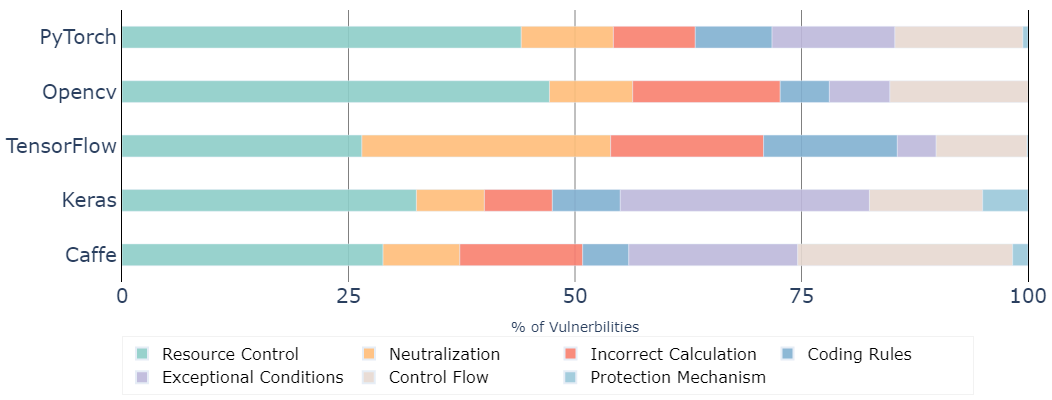

In [46]:
 # colors  
colors = []
def hex_to_rgb(hex):
    rgb = []
    hex = hex[1:]
    for i in (0, 2, 4):
        decimal = int(hex[i:i+2], 16)
        rgb.append(decimal)
    return tuple(rgb)
# Color [Light24, G10, Plotly, D3]
for hex in list(FIG_COLOR):
    rgb = hex_to_rgb(hex)
    colors.append(f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{1.0})')

fig = px.bar(df_, x="Portion", y="Framework", color="CWE Pillar",
             orientation='h',height=400,width=1000, 
             color_discrete_sequence=colors)

fig.update_layout(font_size=12,
                  yaxis={'visible': True, 'showticklabels': True, 'categoryorder':'total ascending', 'title':None}, 
                  xaxis={'visible': True, 'showticklabels': True, 'categoryorder':'total ascending', 'title':None, 
                         'dtick': 25, 'range':[0, 100], 'gridcolor':'grey', 'title':'% of Vulnerbilities','tickfont':dict(size=20)},
                  legend=dict(title='', bordercolor="Gray",borderwidth=0.1, orientation='h',x=0,y=-0.2, 
                              font=dict(size=16, color="black"), itemsizing="constant", itemwidth=30),
                  margin=dict(l=5, r=5, t=10, b=10),height=400, width=1000, bargap=0.6,
                  paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showline=True, linewidth=1, linecolor='Black', mirror=True, tickfont=dict(size=20))
fig.update_traces(opacity=0.9)
fig.show()
fig.write_image(f"imgs/vuln_percentage_framework.pdf", format="pdf")

### Figure 12: Distribution of vulnerabilities in each CWE pillar.

In [47]:
df_ = df[['CWE Pillar','Framework']].copy()
df_['Count'] = 0
df_['Count'] = df_.groupby(['CWE Pillar','Framework'])['CWE Pillar'].transform('count')
df_.loc[df['CWE Pillar'] == 'Improper Control of a Resource Through its Lifetime','CWE Pillar']  = 'Resource Control'
df_.loc[df['CWE Pillar'] == 'Incorrect Calculation','CWE Pillar']                                = 'Incorrect Calculation'
df_.loc[df['CWE Pillar'] == 'Insufficient Control Flow Management','CWE Pillar']                 = 'Control Flow'
df_.loc[df['CWE Pillar'] == 'Protection Mechanism Failure','CWE Pillar']                         = 'Protection Mechanism'
df_.loc[df['CWE Pillar'] == 'Improper Check or Handling of Exceptional Conditions','CWE Pillar'] = 'Exceptional Conditions'
df_.loc[df['CWE Pillar'] == 'Improper Neutralization','CWE Pillar']                              = 'Neutralization'
df_.loc[df['CWE Pillar'] == 'Improper Adherence to Coding Standards','CWE Pillar']               = 'Coding Rules'
df_ = df_.drop_duplicates().reset_index(drop=True)
df_ = df_[df_['CWE Pillar'] != 'Other']

df_.loc[df_['Framework'] == 'tensorflow','Framework'] = 'TensorFlow'
df_.loc[df_['Framework'] == 'pytorch','Framework'] = 'PyTorch'
df_.loc[df_['Framework'] == 'opencv','Framework'] = 'Opencv'
df_.loc[df_['Framework'] == 'keras','Framework'] = 'Keras'
df_.loc[df_['Framework'] == 'caffe','Framework'] = 'Caffe'

df_['Framework Count'] = df_.groupby(['Framework'])['Count'].transform('sum')
df_['Portion'] = df_['Count'] / df_['Framework Count'] * 100

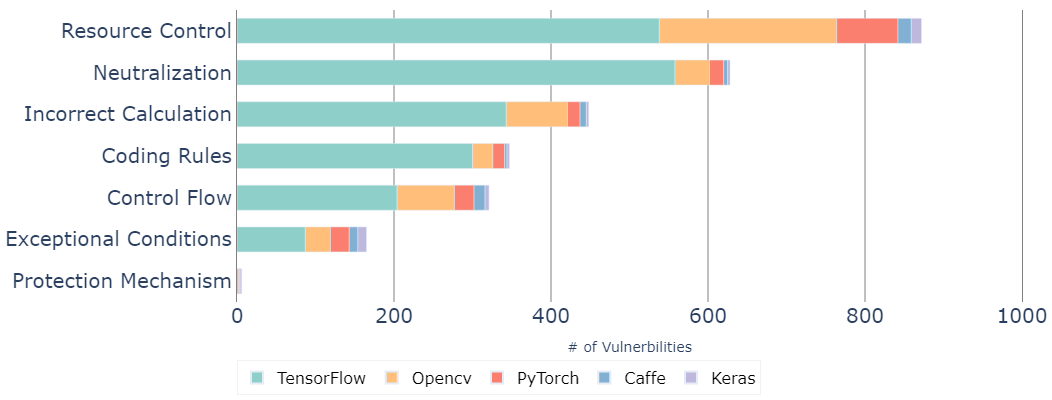

In [48]:
 # colors  
colors = []
def hex_to_rgb(hex):
    rgb = []
    hex = hex[1:]
    for i in (0, 2, 4):
        decimal = int(hex[i:i+2], 16)
        rgb.append(decimal)
    return tuple(rgb)
# Color [Light24, G10, Plotly, D3]
# for hex in list(px.colors.qualitative.D3):
for hex in list(SCI_COLOR):
    rgb = hex_to_rgb(hex)
    colors.append(f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{1.0})')

fig = px.bar(df_, x="Count", y="CWE Pillar", color="Framework",
             orientation='h',height=400,width=1000, 
             color_discrete_sequence=colors)

fig.update_layout(font_size=12,
                  yaxis={'visible': True, 'showticklabels': True, 'categoryorder':'total ascending', 'title':None,'tickfont':dict(size=20)}, 
                  xaxis={'visible': True, 'showticklabels': True, 'categoryorder':'total ascending', 'title':None,
                         'dtick': 200, 'range':[0, 1000], 'gridcolor':'grey', 'title':'# of Vulnerbilities','tickfont':dict(size=20)},
                  legend=dict(title='', bordercolor="Gray",borderwidth=0.1, orientation='h',x=0,y=-0.2, 
                              font=dict(size=16, color="black"), itemsizing="constant", itemwidth=30),
                  margin=dict(l=5, r=5, t=10, b=10),height=400, width=1000, bargap=0.4,
                  paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showline=True, linewidth=1, linecolor='Gray', mirror=True)

fig.show()
fig.write_image(f"imgs/vuln_percentage_pillar.pdf", format="pdf")